In [21]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm import tqdm
import random

from dare import Riccati
from device import device
from env_setup import *
from human import HumanRobotEnv
from models import ThetaEstimatorMLP, ThetaEstimatorTransformer

In [22]:
#@title Simulate how human updates the internal model

sim_policy = dict()
sim_policy['human_state'] = 'varying'
sim_policy['mental_state'] = 'varying'

def gen_physical_state(x1_lo, x2_lo, x1_hi, x2_hi):
    if sim_policy['human_state'] == 'fixed':
        return np.array([[5.0], [2.0]])
    elif sim_policy['human_state'] == 'varying':
        x1 = random.uniform(x1_lo, x1_hi)
        x2 = random.uniform(x2_lo, x2_hi)
        return np.array([[x1], [x2]])
    else:
        raise ValueError("unknown sim_policy['human_state']")
    
def gen_mental_state():
    if sim_policy['mental_state'] == 'fixed':
        return np.array([[1.0]])
    elif sim_policy['mental_state'] == 'varying':
        x = random.uniform(0.0, 1.0)
        return np.array([[x]])
    else:
        raise ValueError("unknown sim_policy['mental_state']")

# totaol simulation steps
sim_time = 20
n_demo   = 10

human_mode = 'gradient_decent'
#human_mode = 'gradient_decent_threshold'

# store the training data
robot_state_all_demo        = []
human_action_all_demo       = []
human_obs_all_demo          = []
human_mental_state_all_demo = []
for i in tqdm(range(n_demo)):
    human_env = HumanRobotEnv('passive_teaching', 1.0, 'use_model_human', True)
    human_env.set_environment(A, B, Q, R, None, None, sim_time)
    human_env.set_action_set(None, u_t0_R_aug_set)
    human_env.set_human_internal_model(None)

    x1_lo = human_env.observation_space.low[0]
    x2_lo = human_env.observation_space.low[1]
    x1_hi = human_env.observation_space.high[0]
    x2_hi = human_env.observation_space.high[1]
    
    # Initialize the robot state [0.4; 0], human mental state [1.0] (human thinks B[1,0]=1.0)
    human_env.set_human_state(gen_physical_state(x1_lo, x2_lo, x1_hi, x2_hi),
                              gen_mental_state())
    
    human_env.noisy_human = False
    for i in range(sim_time):
        human_env.step(None)
    
    robot_state_all_demo.append(human_env.current_demo_state_traj)
    human_action_all_demo.append(human_env.current_demo_human_action_traj)
    human_obs_all_demo.append(human_env.current_demo_human_obs_traj)
    human_mental_state_all_demo.append(human_env.current_demo_human_mental_state_traj)

print('Trajectories: {}'.format(n_demo))

100%|██████████| 10/10 [00:00<00:00, 73.54it/s]

Trajectories: 10


### Visualize the simulated human trajectory

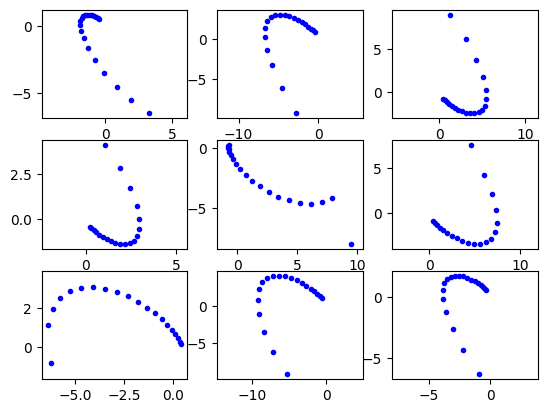

In [14]:
# #@title Visualize the simulated human trajectory
# human_traj = np.array(human_env.current_demo_state_traj).squeeze()
# plt.plot(human_traj[:,0],human_traj[:,1],'bo', markersize=5)
# plt.xlim([-1, 1])
# plt.ylim([-1, 1])
# plt.axis('equal')
# plt.xlabel('x[0] [m]')
# plt.ylabel('x[1] [m/s]')
# plt.show()
# print('The robot starts at 0.4 m with 0 speed. Its goal is to achieve [0;0]. \
# Note that the robot decelerates first, then accelerates')

fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        idx = (i*3) + j
        human_traj = np.array(robot_state_all_demo[idx]).squeeze()
        ax.plot(human_traj[:,0],human_traj[:,1],'bo', markersize=3)
        ax.axis(xmin=-1, xmax=1, ymin=-1, ymax=1)
        ax.axis('equal')

### Visualize the simulated human internal model

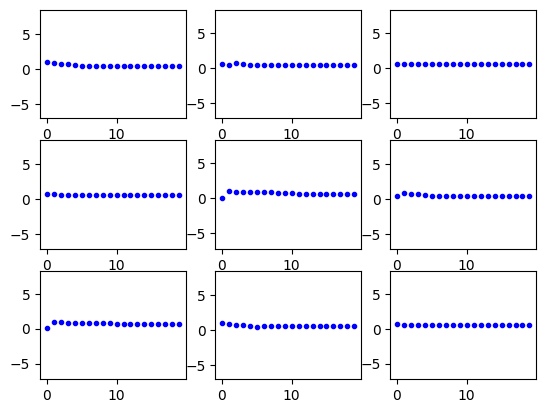

In [15]:
# #@title Visualize the simulated human internal model
# human_internal_state_traj = np.array(human_env.current_demo_human_mental_state_traj).squeeze()
# plt.plot(human_internal_state_traj, 'bo', markersize=5)
# plt.ylim([0.3, 1.0])
# plt.xlabel('Time')
# plt.ylabel('Human\'s internal B[1,0]')
# plt.show()
# print('Note that here human\'s estination of B[1,0] starts from 1.0, then slowly approaches to the correct value (0.5).')

fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        ax = axs[i][j]
        idx = (i*3) + j
        human_internal_state_traj = np.array(human_mental_state_all_demo[idx]).squeeze()
        ax.plot(human_internal_state_traj, 'bo', markersize=3)
        ax.axis(ymin=-2.0, ymax=2.0)
        ax.axis('equal')

### Pre-processing trajectory data for estimator

In [16]:
# # Assemble data into matrix
# states = [s[0].T for s in robot_state_all_demo[0]]
# states = np.concatenate(states)

# actions = [a[0].T for a in human_action_all_demo[0]]
# actions = np.concatenate(actions)

# mental_states = [s[0].T for s in human_mental_state_all_demo[0]]
# mental_states = np.concatenate(mental_states)
# mental_states = torch.tensor(mental_states).to(device)

# sa_tuples = np.concatenate((states, actions), axis=1)

# # Create normalizer
# scaler = StandardScaler()
# scaler.fit(sa_tuples)
# norm_sa_tuples = scaler.transform(sa_tuples)

# # Put inputs into tensors
# sa_tuples = torch.tensor(sa_tuples).to(device)
# norm_sa_tuples = torch.tensor(norm_sa_tuples).to(device)
# states = sa_tuples[:, :2]
# actions = sa_tuples[:, 2:]
# norm_states = norm_sa_tuples[:, :2]
# norm_actions = norm_sa_tuples[:, 2:]

# N = states.shape[0]
# print(N)

In [17]:
states = torch.tensor(robot_state_all_demo, device=device)
states = states.view(n_demo * sim_time, nX)

actions = torch.tensor(human_action_all_demo, device=device)
actions = actions.view(n_demo * sim_time, nU)

inputs = torch.cat((states, actions), axis=1)
inputs = inputs.view(n_demo, sim_time, nX + nU).double()
print(inputs.shape)

torch.Size([10, 20, 3])


### Train $\theta_H$ estimator E2E with LQR

In [18]:
EPOCHS = 100
# theta_H_estimator = ThetaEstimatorMLP().to(device).double()
# theta_H_estimator.train()
# optimizer = torch.optim.Adam(theta_H_estimator.parameters(), lr=0.1)

transformer_estimator = ThetaEstimatorTransformer().to(device).double()
transformer_estimator.train()
optimizer = torch.optim.Adam(transformer_estimator.parameters(), lr=10.0)

In [19]:
def predict_action(state, theta_H):
    B_hat_tensor = theta_H * torch.tensor([[0., ],[1.0]], device = device).double()
    P_hat = Riccati.apply(A_tensor, B_hat_tensor, Q_tensor, R_tensor)

    K = torch.linalg.multi_dot((
        torch.linalg.pinv(torch.add(
            R_tensor,
            torch.linalg.multi_dot((torch.transpose(B_hat_tensor, 0, 1), P_hat, B_hat_tensor))
        )),
        torch.transpose(B_hat_tensor, 0, 1),
        P_hat,
        A_tensor
    ))
    action_pred = torch.neg(torch.matmul(K, state))
    return action_pred

def transformer_step(model, inputs):
    inputs = inputs.reshape(-1, inputs.shape[0], inputs.shape[1])
    theta_Hs = model(inputs)
    theta_Hs = theta_Hs.reshape(sim_time)

    step_losses = []
    for i in range(sim_time - 1):
        theta_H = theta_Hs[i]
        input = inputs[0][i]
        state, action = torch.split(input, [2, 1])
        
        action_pred = predict_action(state, theta_H)
        loss_fn = nn.MSELoss()
        loss = loss_fn(action_pred, action)
        step_losses.append(loss)
    
    optimizer.zero_grad()
    step_loss = sum(step_losses)
    step_loss.backward()
    optimizer.step()
    
    return loss.data.item(), theta_H.data.item()

100%|██████████| 1000/1000 [00:15<00:00, 64.83it/s]


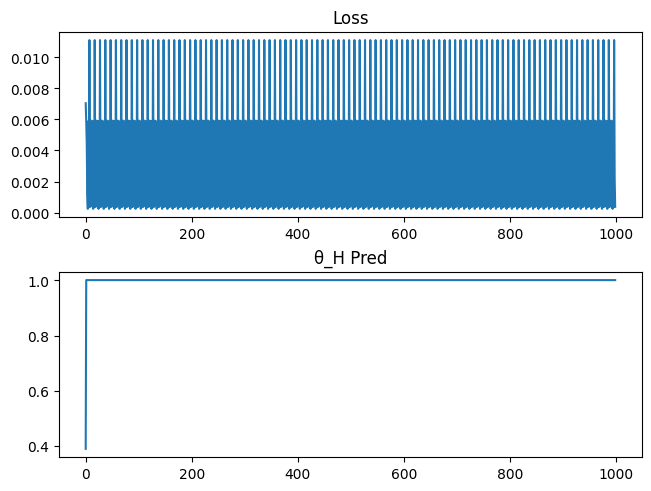

In [20]:
loss_list, theta_H_list = [], []
for epoch in tqdm(range(EPOCHS * n_demo)):
    curr_demo_idx = epoch % n_demo
    curr_demo = inputs[curr_demo_idx]
    loss, theta_H = transformer_step(transformer_estimator, curr_demo)
    loss_list.append(loss)
    theta_H_list.append(theta_H)

fig, axs = plt.subplots(2, constrained_layout=True)
axs[0].plot(range(EPOCHS * n_demo), loss_list)
axs[1].plot(range(EPOCHS * n_demo), theta_H_list)
axs[0].title.set_text('Loss')
axs[1].title.set_text('θ_H Pred')

In [10]:
# loss_list, theta_H_list, theta_H_true_list = [], [], []
# for epoch in tqdm(range(EPOCHS)):
#     for idx in range(N):
#         # idx = randrange(N)
#         # idx = 0
#         state, action, mental_state = states[idx], actions[idx], mental_states[idx]
#         norm_state, norm_action = norm_states[idx], norm_actions[idx]
#         loss, theta_H = step(state, action, norm_state, norm_action)
#         loss_list.append(loss)
#         theta_H_list.append(theta_H)
#         theta_H_true_list.append(mental_state.data.item())
#     # print('Epoch {}: Loss={}, theta_H={}'.format(epoch, loss, theta_H))

# fig, axs = plt.subplots(3, constrained_layout=True)
# axs[0].plot(range(EPOCHS * N), loss_list)
# axs[1].plot(range(EPOCHS * N), theta_H_list)
# axs[2].plot(range(EPOCHS * N), theta_H_true_list)
# axs[0].title.set_text('Loss')
# axs[1].title.set_text('θ_H Pred')
# axs[2].title.set_text('θ_H True')

In [11]:
# def mlp_step(state, action, norm_state, norm_action):
#     input = torch.cat((norm_state, norm_action)).reshape(-1)
#     theta_H = theta_H_estimator(input)
#     # theta_H = torch.clamp(theta_H_estimator(input), min=0.001, max=1.0)
#     action_pred = predict_action(state, theta_H)

#     optimizer.zero_grad()
#     loss_fn = nn.MSELoss()
#     loss = loss_fn(action_pred, action)
#     loss.backward()
#     optimizer.step()

#     # action_dist = torch.norm(action_pred - action)
#     # print('Epoch: Loss={}, theta_H={}, action_pred={}, action={}, action_dist={}'.format(loss.data.item(), theta_H.data.item(), action_pred.data.item(), action.data.item(), action_dist.data.item()))
#     # print('Epoch: Loss={}, theta_H={}'.format(loss.data.item(), theta_H.data.item()))

#     return loss.data.item(), theta_H.data.item()